# Time Series Modelling and Approaches 

# Introduction

**Goal: Forecast daily wave energy 

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
#read in cleaned buoy data 
df = pd.read_csv('../Data/combined_buoy_hindcast.csv')

In [3]:
df.head()

,STN_ID,Datetime_x,Q_FLAG,LATITUDE,LONGITUDE,DEPTH,VWH$,VCMX,VTP$,WDIR,...,ETTSw,TPSw,VMDSw,MO1,MO2,HS,DMDIR,ANGSPR,INLINE,Datetime_y
0,C46206,1988-11-22 22:34:00,1,48.83,126.0,73.0,5.42,8.4,11.64,234.0,...,0.844,12.229,63.7,0.682,0.564,3.981,67.0,0.8075,0.7153,1988-11-23 00:00:00
1,C46206,1988-11-23 00:33:00,1,48.83,126.0,73.0,5.89,9.0,14.22,263.0,...,0.844,12.229,63.7,0.682,0.564,3.981,67.0,0.8075,0.7153,1988-11-23 00:00:00
2,C46206,1988-11-23 01:34:00,1,48.83,126.0,73.0,6.49,10.5,12.80,277.0,...,0.844,12.229,63.7,0.682,0.564,3.981,67.0,0.8075,0.7153,1988-11-23 00:00:00
3,C46206,1988-11-23 02:34:00,1,48.83,126.0,73.0,7.34,12.1,15.06,275.0,...,0.844,12.229,63.7,0.682,0.564,3.981,67.0,0.8075,0.7153,1988-11-23 00:00:00
4,C46206,1988-11-23 04:34:00,1,48.83,126.0,73.0,7.71,13.0,14.22,295.0,...,0.844,12.229,63.7,0.682,0.564,3.981,67.0,0.8075,0.7153,1988-11-23 00:00:00


# Data Dictionary 

<details>
  <summary>Data Dictionary</summary>
  
### Data Dictionary
**Note on Directions;** Directions are given in degrees corresponding to True North: 
North (N): 0° = 360°
East (E): 90°
South (S): 180°
West (W): 270°

- Index, - DATE : Date time excluding minutes, both df_buoy and df_hind joined on this column.
- STN_ID: buoy station ID.
- Datetime_x: Datetime from df_buoy
- DEPTH: Depth in meters.
- VWH\$: Characteristic significant wave height (reported by the buoy) (m)
- VCMX: Maximum zero crossing wave height (reported by the buoy) (m)
- VTP\$: Wave spectrum peak period (reported by the buoy) (s)
- WDIR: Direction from which the wind is blowing (° True)
- WSPD: Horizontal wind speed (m/s)
- WSS\$:Horizontal scalar wind speed (m/s)
- GSPD: Gust wind speed (m/s)
- ATMS: Atmospheric pressure at sea level (mbar)
- DRYT: Dry bulb temperature (air temperature) (°C)
- SSTP: Sea surface temperature (°C)
- Q_FLAG: 0
    - Blank - No quality control (QC) has been performed
    - 1- Good - QC has been performed: record appears correct
    - 3-Doubtful - QC has been performed: record appears doubtful
    - 4-Erroneous - QC has been performed: record appears erroneous
    - 5-Changes - The record has been changed as a result of QC
    - 6-Acceptable - QC has been performed: record seems inconsistent with other records
    - 7-Off Position - There is a problem with the buoy position or mooring. Data may still be useful.
    - 8-Reserved
    - 9-Reserved - indicates missing elements
- Datetime_y  - Date time in 3 hour intervals from df_hind
- WD          - Wind Direction (deg from which wind is blowing (° True))
- WS          - Wind Speed (m/s)
- ETOT        - Total Variance of Total Spectrum (m^2)
- TP          - Peak Spectral Period of Total Spectrum (sec)
- VMD         - Vector Mean Direction of Total Spectrum (deg to which)
- ETTSea      - Total Variance of Primary Partition (m^2)
- TPSea       - Peak Spectral Period of Primary Partition (sec)
- VMDSea      - Vector Mean Direction of Primary Partition (deg to which)
- ETTSw       - Total Variance of Secondary Partition (m^2)
- TPSw        - Peak Spectral Period of Secondary Partition (sec)
- VMDSw       - Vector Mean Direction of Secondary Partition (deg to which)
- MO1         - First Spectral Moment of Total Spectrum (m^2/s)
- MO2         - Second Spectral Moment of Total Spectrum (m^2/s^2)
- HS          - Significant Wave Height (m)
- DMDIR       - Dominant Direction (deg to which)
- ANGSPR      - Angular Spreading Function
- INLINE      - In-Line Variance Ratio
 
</details>

# Methodology

# PreProcessing for TimeSeries

The goal is to create a daily forecast, first check to make sure there are no major gaps in data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199026 entries, 0 to 199025
Data columns (total 38 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   STN_ID      199026 non-null  object 
 1   Datetime_x  199026 non-null  object 
 2   Q_FLAG      199026 non-null  int64  
 3   LATITUDE    199026 non-null  float64
 4   LONGITUDE   199026 non-null  float64
 5   DEPTH       199026 non-null  float64
 6   VWH$        199026 non-null  float64
 7   VCMX        199026 non-null  float64
 8   VTP$        199026 non-null  float64
 9   WDIR        199026 non-null  float64
 10  WSPD        199026 non-null  float64
 11  GSPD        199026 non-null  float64
 12  WDIR.1      199026 non-null  float64
 13  WSPD.1      199026 non-null  float64
 14  GSPD.1      199026 non-null  float64
 15  ATMS        199026 non-null  float64
 16  DRYT        199026 non-null  float64
 17  SSTP        199026 non-null  float64
 18  YEAR        199026 non-null  int64  
 19  DA

In [5]:
#convert Date columns to datetime
df['Datetime_x']=pd.to_datetime(df['Datetime_x'])
df['Datetime_y'] =pd.to_datetime(df['Datetime_y'])

In [6]:
#rename columns for clarity 
df.rename(columns={'Datetime_x': 'Datetime_buoy', 'Datetime_y':'Datetime_hind'},inplace=True)

In [7]:
df[['Datetime_buoy','Datetime_hind']]

,Datetime_buoy,Datetime_hind
0,1988-11-22 22:34:00,1988-11-23 00:00:00
1,1988-11-23 00:33:00,1988-11-23 00:00:00
2,1988-11-23 01:34:00,1988-11-23 00:00:00
3,1988-11-23 02:34:00,1988-11-23 00:00:00
4,1988-11-23 04:34:00,1988-11-23 00:00:00
...,...,...
199021,2016-01-01 16:38:00,2016-01-01 15:00:00
199022,2016-01-01 17:38:00,2016-01-01 15:00:00
199023,2016-01-01 18:38:00,2016-01-01 18:00:00
199024,2016-01-01 19:38:00,2016-01-01 18:00:00


In [8]:
#check for gaps data should already be in sequential order

time_diff_buoy = df['Datetime_buoy'].diff() #calculates difference bewteen timestamps
# set expected interval
expected_interval = pd.to_timedelta(1, unit='H')
#indentify gaps -> create seperate data frame based on boolean condition
gaps_buoy = df[time_diff_buoy>expected_interval]



In [9]:
gaps_buoy.shape

(8151, 38)

There are gaps in the datetime of buoy hourly data. This makes up about 24% of data. Investigate where gaps are and how large. 

In [10]:
gaps_buoy['Datetime_buoy']

1        1988-11-23 00:33:00
2        1988-11-23 01:34:00
4        1988-11-23 04:34:00
20       1988-11-23 20:34:00
24       1988-11-24 00:34:00
                 ...        
193154   2015-05-01 23:38:00
193155   2015-05-02 02:38:00
193158   2015-05-02 07:38:00
193160   2015-05-02 10:38:00
193224   2015-05-05 03:38:00
Name: Datetime_buoy, Length: 8151, dtype: datetime64[ns]

In [11]:
#find duration of gaps
gap_durations = time_diff_buoy[time_diff_buoy > expected_interval]
duration_vals_gaps = gap_durations.value_counts() 
print('Duration counts of the gaps')
print(duration_vals_gaps)

Duration counts of the gaps
Datetime_buoy
0 days 02:00:00     4801
0 days 03:00:00     1060
0 days 01:01:00      912
0 days 04:00:00      404
0 days 05:00:00      201
                    ... 
4 days 11:00:00        1
14 days 16:00:00       1
0 days 01:27:00        1
0 days 02:33:00        1
95 days 06:00:00       1
Name: count, Length: 144, dtype: int64


In [12]:
# Set the threshold for gap duration to 30 days
threshold_duration = pd.to_timedelta(30, unit='D')
# Count the number of gap durations greater than 30 days
num_long_gaps = (gap_durations > threshold_duration).sum()

# Print or display the result
print("Number of Gaps Greater Than 30 Days:", num_long_gaps)

Number of Gaps Greater Than 30 Days: 8


In [13]:
long_gaps = gap_durations[gap_durations > threshold_duration]

# Print or display the durations of gaps greater than 30 days
print("Gap Durations Greater Than 30 Days:")
print(long_gaps)

Gap Durations Greater Than 30 Days:
3615      79 days 11:01:00
47851     50 days 16:00:00
92910    129 days 02:00:00
126754    43 days 12:00:00
131586    33 days 17:00:00
161552    30 days 05:00:00
173895    31 days 18:00:00
184402    95 days 06:00:00
Name: Datetime_buoy, dtype: timedelta64[ns]


In [14]:
#max gap duration
max_gap_duration = gap_durations.max()
print('max duration of gap:', max_gap_duration)

max duration of gap: 129 days 02:00:00


In [15]:
# Find the index of the maximum gap duration
max_gap_index = gap_durations[gap_durations == max_gap_duration].index[0]

# Extract rows corresponding to the exact 129-day gap
exact_gap_rows = df.loc[max_gap_index - 1:max_gap_index + 1]

# Print or visualize the information
print("Maximum Gap Duration:")
print(max_gap_duration)
print("Rows corresponding to the exact 129-day gap:")
print(exact_gap_rows)

Maximum Gap Duration:
129 days 02:00:00
Rows corresponding to the exact 129-day gap:
       STN_ID       Datetime_buoy  Q_FLAG  LATITUDE  LONGITUDE  DEPTH  VWH$  \
92909  C46206 2001-09-29 22:45:00       1     48.83      126.0   75.0   0.0   
92910  C46206 2002-02-06 00:45:00       7     48.83      126.0   75.0   0.0   
92911  C46206 2002-02-06 01:45:00       7     48.83      126.0   75.0   0.0   

       VCMX  VTP$   WDIR  ...  ETTSw    TPSw  VMDSw    MO1    MO2     HS  \
92909   0.0   2.9  173.0  ...  0.252  10.182   59.6  0.315  0.352  2.361   
92910   0.0   3.3  221.0  ...  0.276  11.515   51.6  1.052  1.049  4.452   
92911   0.0  36.6  234.0  ...  0.276  11.515   51.6  1.052  1.049  4.452   

       DMDIR  ANGSPR  INLINE       Datetime_hind  
92909   52.2  0.7088  0.6105 2001-09-29 21:00:00  
92910    5.5  0.7699  0.6705 2002-02-06 00:00:00  
92911    5.5  0.7699  0.6705 2002-02-06 00:00:00  

[3 rows x 38 columns]


In [16]:
#range of datetime for datetime_buoy
min_datetime = df['Datetime_buoy'].min()
max_datetime = df['Datetime_buoy'].max()

print("Minimum Datetime:", min_datetime)
print("Maximum Datetime:", max_datetime)

Minimum Datetime: 1988-11-22 22:34:00
Maximum Datetime: 2016-01-01 20:38:00


### Approach to Handling Gaps in Datetime

Since forecasting will be on the granularity of a 'Day', a new dataframe for time series will be constructed with the average values for each feature for each day. The missing days will then be imputed.  **HOW**?????

**STEP 1** Create new timeseries dataframe by resampling to day granularity

In [17]:
#reset index to Datetime_buoy
df.set_index('Datetime_buoy', inplace=True)


In [18]:
cols_to_drop = ['STN_ID','DATE','Q_FLAG','DATE','Datetime_hind']
df_daily = df.drop(columns=cols_to_drop).copy()

In [21]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 199026 entries, 1988-11-22 22:34:00 to 2016-01-01 20:38:00
Data columns (total 33 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   LATITUDE   199026 non-null  float64
 1   LONGITUDE  199026 non-null  float64
 2   DEPTH      199026 non-null  float64
 3   VWH$       199026 non-null  float64
 4   VCMX       199026 non-null  float64
 5   VTP$       199026 non-null  float64
 6   WDIR       199026 non-null  float64
 7   WSPD       199026 non-null  float64
 8   GSPD       199026 non-null  float64
 9   WDIR.1     199026 non-null  float64
 10  WSPD.1     199026 non-null  float64
 11  GSPD.1     199026 non-null  float64
 12  ATMS       199026 non-null  float64
 13  DRYT       199026 non-null  float64
 14  SSTP       199026 non-null  float64
 15  YEAR       199026 non-null  int64  
 16  WD         199026 non-null  float64
 17  WS         199026 non-null  float64
 18  ETOT       199026 non-null  fl

In [22]:
#resample entire data frame for 'D' and use .mean()
df_daily = df_daily.resample('D').mean()

In [23]:
df_daily.head()

,LATITUDE,LONGITUDE,DEPTH,VWH$,VCMX,VTP$,WDIR,WSPD,GSPD,WDIR.1,...,VMDSea,ETTSw,TPSw,VMDSw,MO1,MO2,HS,DMDIR,ANGSPR,INLINE
Datetime_buoy,,,,,,,,,,,,,,,,,,,,,
1988-11-22,48.83,126.0,73.0,5.420000,8.400000,11.640000,234.000000,11.800000,15.600000,225.000000,...,32.200000,0.844000,12.229000,63.700000,0.682000,0.564000,3.981000,67.000000,0.807500,0.715300
1988-11-23,48.83,126.0,73.0,6.657391,11.591304,14.960000,265.695652,7.491304,10.630435,256.086957,...,21.869565,0.661391,13.783913,76.808696,1.459913,1.249043,5.604522,52.469565,0.771422,0.673013
1988-11-24,48.83,126.0,73.0,4.434286,7.861905,15.097143,187.095238,6.809524,9.252381,177.619048,...,68.300000,1.774143,14.318143,75.528571,2.440857,1.881714,7.755571,75.142857,0.850457,0.765200
1988-11-25,48.83,126.0,73.0,3.676087,6.047826,13.973913,200.956522,6.026087,8.152174,191.739130,...,44.073913,1.157522,14.076913,88.278261,0.799304,0.618565,4.529000,87.786957,0.859587,0.789322
1988-11-26,48.83,126.0,73.0,3.114091,5.440909,11.930909,236.500000,5.613636,7.395455,227.227273,...,79.350000,0.711591,13.506682,76.372727,0.769818,0.690773,4.112773,89.922727,0.819845,0.757150


In [24]:
df_daily.isnull().sum()

LATITUDE     918
LONGITUDE    918
DEPTH        918
VWH$         918
VCMX         918
VTP$         918
WDIR         918
WSPD         918
GSPD         918
WDIR.1       918
WSPD.1       918
GSPD.1       918
ATMS         918
DRYT         918
SSTP         918
YEAR         918
WD           918
WS           918
ETOT         918
TP           918
VMD          918
ETTSea       918
TPSea        918
VMDSea       918
ETTSw        918
TPSw         918
VMDSw        918
MO1          918
MO2          918
HS           918
DMDIR        918
ANGSPR       918
INLINE       918
dtype: int64

**STEP 2** Impute missing values

For ARIMA and SARIMA model , just ETOT will be used for forecasting. Past predictions of itself. A copy of daily resampled dataframe will be made and values will be imputed based on corresponding day means from other years. The approach to imputing values may be revisited. For now this will be tried. 

In [28]:
df_daily_imputed = df_daily.copy()

In [31]:
features = [
    'LATITUDE', 'LONGITUDE', 'DEPTH', 'VWH$', 'VCMX', 'VTP$', 'WDIR', 'WSPD', 'GSPD',
    'WDIR.1', 'WSPD.1', 'GSPD.1', 'ATMS', 'DRYT', 'SSTP', 'YEAR', 'WD', 'WS', 'ETOT',
    'TP', 'VMD', 'ETTSea', 'TPSea', 'VMDSea', 'ETTSw', 'TPSw', 'VMDSw', 'MO1', 'MO2',
    'HS', 'DMDIR', 'ANGSPR', 'INLINE'
]

#create for loop to iterate through each feature and replace missing days
#.dayofyear used to find corresponding days from other years

#outer loop, iterature through the features
for feature in features:
    missing_days = df_daily_imputed[df_daily_imputed[feature].isnull()].index #get indicies of missing days
    #inner loop,for each feature iterate over the days with missing values 
    for day in missing_days:
        #find corresponding days in other years by using index.month, index.day (ensure day is from correct month)
        corresponding_day = df_daily_imputed.index[
            (df_daily_imputed.index.month==day.month) & #month of current day matches month of timestamp
            (df_daily_imputed.index.day==day.day) #day of month matches
        ] 
        #impute missing values with mean of corresponding days
        df_daily_imputed.loc[day,feature] = df_daily_imputed.loc[corresponding_day,feature].mean()
    

In [32]:
df_daily_imputed.isnull().sum()

LATITUDE     0
LONGITUDE    0
DEPTH        0
VWH$         0
VCMX         0
VTP$         0
WDIR         0
WSPD         0
GSPD         0
WDIR.1       0
WSPD.1       0
GSPD.1       0
ATMS         0
DRYT         0
SSTP         0
YEAR         0
WD           0
WS           0
ETOT         0
TP           0
VMD          0
ETTSea       0
TPSea        0
VMDSea       0
ETTSw        0
TPSw         0
VMDSw        0
MO1          0
MO2          0
HS           0
DMDIR        0
ANGSPR       0
INLINE       0
dtype: int64

Values have been imputed. 

In [33]:
df_daily_imputed.shape

(9902, 33)

In [34]:
min_date = df_daily_imputed.index.min()
max_date = df_daily_imputed.index.max()

print("Minimum Date:", min_date)
print("Maximum Date:", max_date)

Minimum Date: 1988-11-22 00:00:00
Maximum Date: 2016-01-01 00:00:00


# PreProcessing and Modelling

Now that values have been imputed the data will be split into a train test split based on datetime. 
The data will be split from 1988-2008 leaving 8 years for testing and 20 years for training. 

**Train Test Split**

In [36]:
#train test split
cut_off_date = '2009-01-01'

train_set = df_daily_imputed[df_daily_imputed.index < cut_off_date]
test_set = df_daily_imputed[df_daily_imputed.index >= cut_off_date]

In [37]:
max_train_date =train_set.index.max()
print(max_train_date)

2008-12-31 00:00:00


## First Model: ARMA or ARIMA
The target will be decomposed and assessed as to weather variable is stationary or if there are trends present

**Decomposition**

Decompose target into components.

In [39]:
#create dataframe with datetime index and target
etot_data = train_set[['ETOT']].copy()

<Axes: xlabel='Datetime_buoy'>

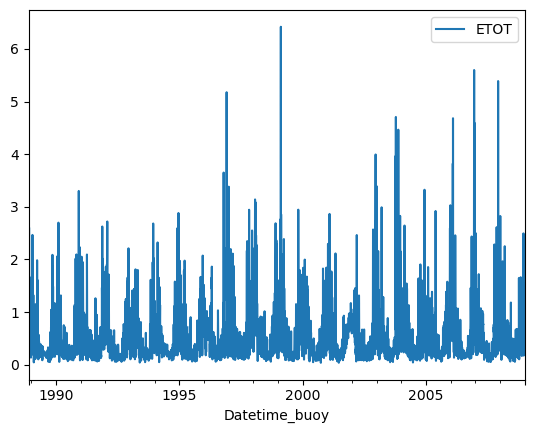

In [41]:
#plot etot
etot_data.plot()

Appears to be reoccuring spikes in ETOT, but no overall trends. 

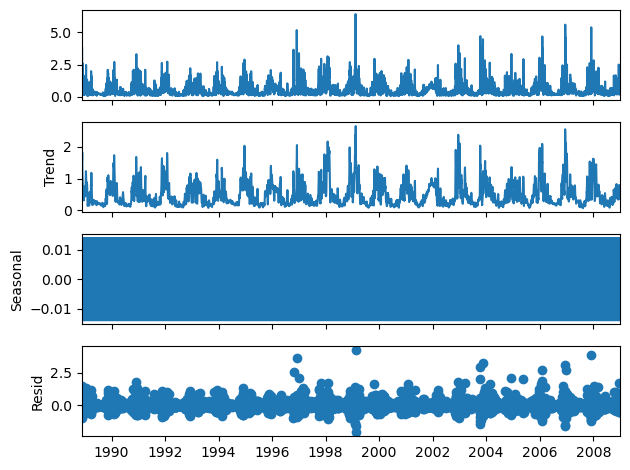

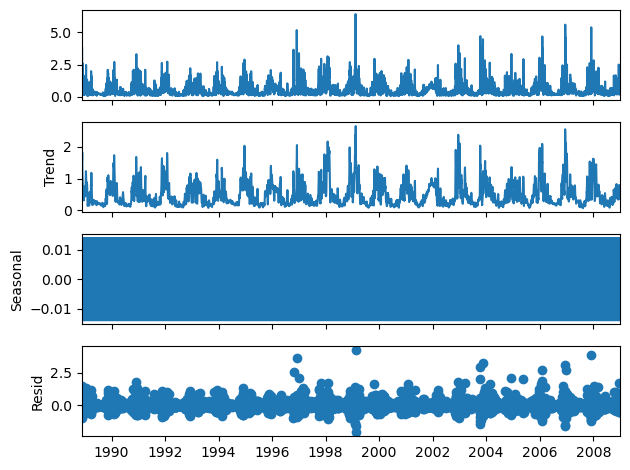

In [43]:
#decompose
result_decomp = seasonal_decompose(etot_data)
result_decomp.plot()

In [46]:
#AD fuller test for stationarity
result_adf = adfuller(etot_data['ETOT'])

test_statistic= result_adf[0]
p_val = result_adf[1]
print(f'Test Statistic: {test_statistic}')
print(f'P-Value: {p_val}')

Test Statistic: -7.302503819290496
P-Value: 1.327300919561392e-10


Results from ADF test with a low p-value less than 0.05  gives evidence to reject the null hypothesis that unit root is present in timeseries. Data is stationary. ARMA will be used as differencing does not need to be done. 

### Autocorrelation
**ACF and PACF**
Use ACF and PACF to analyze autocorrelation. Look for positive or negative  autocorrelation. 

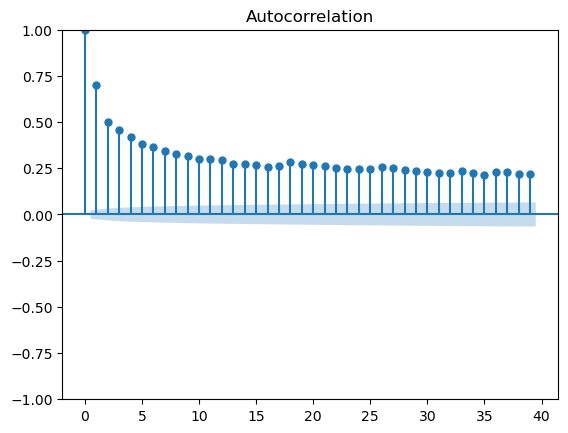

In [51]:
plot_acf(etot_data)
plt.show()

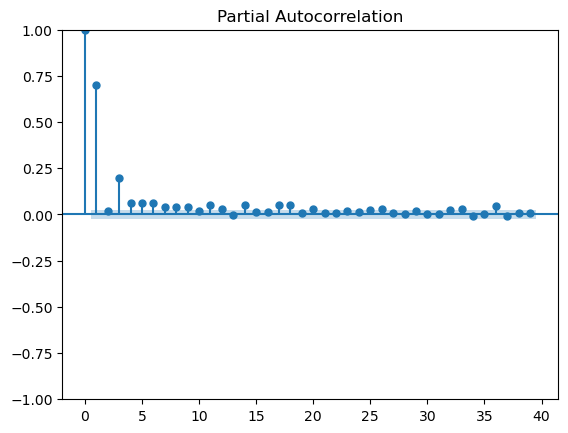

In [52]:
plot_pacf(etot_data)
plt.show()

The ACF plot shows a spike around 2 then consistently decays as the lag increses. This could signify a significant autocorrelation at lag. Also possible seasonality or periodicity. The PACF has a drop almost to zero after lag 1 indicating that once the correlation at lag 1 is considered there is not much direct correlation for higher lags. There is a spike at lag 3 in the PACF plot suggesting a correlation with lag 3 lags back. All auto correlations are positive and no strong negative auto correlations observed. The ARMA model will be used as differencing is not needed as series appears to be stationary. 

## ARMA Model 
The ARMA model will be the first model used, the orders(p,q) will be adjusted based on residual error. Initial values will be specified based on observations from ACF and PACF.

ARMA model: 
- order: 2


## SARIMA MODEL 